In [1]:
from typing_extensions import TypedDict
class state(TypedDict):
    graph_state:str
    


In [2]:
def first_node(state):
    print("my 1st node is called") 
    return {"graph_state":state['graph_state']+" im working on first node"}

def second_node(state):
    print("my 2nd node is called")
    return {"graph_state":state['graph_state']+" im working on second node"}

def third_node(state):
    print("my 3rd node is called")
    return {"graph_state":state['graph_state']+" im working on third node"}

In [3]:
import random
from typing import Literal
def decide_node(state)->Literal["second_node", "third_node"]:
    graph_state = state['graph_state']

    if random.random()<0.5:
        return "second_node"
    
    return "third_node"



# Graph

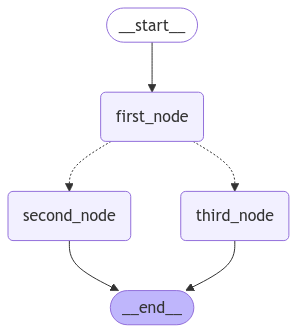

In [4]:
from IPython.display import Image
from langgraph.graph import StateGraph, START, END

# Build the graph
builder = StateGraph(state)

builder.add_node("first_node", first_node)
builder.add_node("second_node", second_node)
builder.add_node("third_node", third_node)

# Logic
builder.add_edge(START,"first_node")
builder.add_conditional_edges("first_node", decide_node)
builder.add_edge("second_node", END)
builder.add_edge("third_node", END)

# Add
graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
graph.invoke({"graph_state": "Hi, my name is Aditya"})


my 1st node is called
my 2nd node is called


{'graph_state': 'Hi, my name is Aditya im working on first node im working on second node'}

# Basic Chatbot

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages



In [21]:
class state(TypedDict):
    messages:Annotated[list, add_messages]

In [22]:
from langgraph.graph import StateGraph, START, END
graph_builder = StateGraph(state)


In [23]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [24]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022207F8AB70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022207F8A3F0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
# def chatbot(state:state):
#     state["messages"].append(llm.invoke(state["messages"][-1]))
#     # return {"messages":[llm.invoke(state['messages'])]}
#     return state

In [26]:
def chatbot(state):
    print("Chatbot node invoked")

    if "messages" not in state:
        raise ValueError("Missing 'messages' in state input!")

    # Limit messages to avoid infinite loop
    if len(state["messages"]) > 5:
        return {"messages": state["messages"] + ["Conversation ended."]}
    
    return {"messages": state["messages"] + ["Chatbot response."]}


In [27]:
graph_builder.add_edge("chatbot", "chatbot")  # Makes it interactive


In [28]:
def user_input(state):
    print("User input node invoked")
    
    user_message = input("You: ")  # Get user input
    
    return {"messages": state["messages"] + [user_message]}  # ✅ Correct format



# Reset graph builder
graph_builder = StateGraph(state)

# Add nodes
graph_builder.add_node("user_input", user_input)
graph_builder.add_node("chatbot", chatbot)  # ✅ This is missing in your code

# Define valid edges
graph_builder.add_edge(START, "user_input")
graph_builder.add_edge("user_input", "chatbot")
graph_builder.add_edge("chatbot", "user_input")  # If looping
graph_builder.add_edge("chatbot", END)  # ✅ Ensure chatbot leads to END

In [30]:
# graph_builder.add_node("chatbot",chatbot)
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)
# graph = graph_builder.compile()

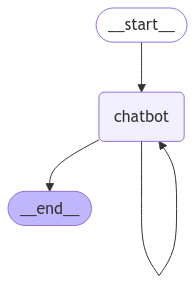

In [31]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
# Debugging
print("Nodes:", graph_builder.nodes.keys())
print("Edges:", graph_builder.edges)

# Compile the graph
graph = graph_builder.compile()


Nodes: dict_keys(['user_input', 'chatbot'])
Edges: {('user_input', 'chatbot'), ('chatbot', '__end__'), ('__start__', 'user_input'), ('chatbot', 'user_input')}


In [33]:
graph = graph_builder.compile()

In [34]:
from time import time

start_time = time()
llm_response = llm.invoke(["Hello"])
end_time = time()

print("Time taken for LLM:", end_time - start_time, "seconds")


Time taken for LLM: 0.366840124130249 seconds


In [35]:
def chatbot(state):
    print("Chatbot node invoked")
    return {"graph_state": state["graph_state"] + " Chatbot processed"}


In [39]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content":user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [40]:
while True:
    try:
        user_input = input("user: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("goodbye!")
            break
        stream_graph_updates(user_input)

    except:
        user_input = "what is langgraph?"
        print("user: "+ user_input)
        stream_graph_updates(user_input)
        break

User input node invoked
user: what is langgraph?
User input node invoked


AttributeError: 'str' object has no attribute 'content'